In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize

from utils import *

plt.style.use('ggplot')

## Data loading

In [92]:

# Salmon price and export volume data from SSB
data_URL = 'https://www.ssb.no/statbank/sq/10085910'
salmon_data = import_salmon_data(data_URL)

# EUR/NOK currency data from yfinance
currency_data = yf.download(
    'EURNOK=X', 
    start=salmon_data.index[0], 
    end=salmon_data.index[-1], 
    interval='1wk', 
    progress=False
)['Adj Close']

com_data = yf.download()

salmon_data.rename({'Kilopris (kr)':'Price', 'Vekt (tonn)': 'Volume'}, inplace=True, axis='columns')

salmon_data['Currency'] = currency_data

salmon_data.dropna(inplace=True)

# Add time lags
add_lags(salmon_data)

display(salmon_data)

,Price,Volume,Currency,Year,Week,Month,Day of year
uke,,,,,,,
2000-03-13,33.29,4797,8.15400,2000,11,3,73
2000-03-20,33.77,5004,8.10650,2000,12,3,80
2000-03-27,34.11,5336,8.08250,2000,13,3,87
2000-04-03,34.61,6091,8.11890,2000,14,4,94
2000-04-10,34.12,6460,8.20900,2000,15,4,101
...,...,...,...,...,...,...,...
2023-07-24,86.14,19604,11.23369,2023,30,7,205
2023-07-31,83.28,20469,11.16050,2023,31,7,212
2023-08-07,80.26,21060,11.41363,2023,32,8,219


## Volume prediction

Mean Squared Error: 15101426.8394


,Importance
Year,0.322014
Week,0.486462
Month,0.047141
Day of year,0.099551
Currency,0.044832


Mean Squared Error: 13119730.4850


,Importance
Year,0.744452
Week,0.143758
Month,0.025474
Day of year,0.073754
Currency,0.012562


Mean Squared Error: 9889107.2213


,Importance
Year,0.783588
Week,0.099732
Month,0.057493
Day of year,0.048963
Currency,0.010224


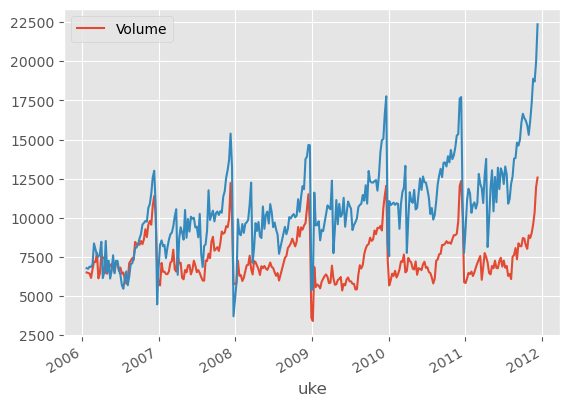

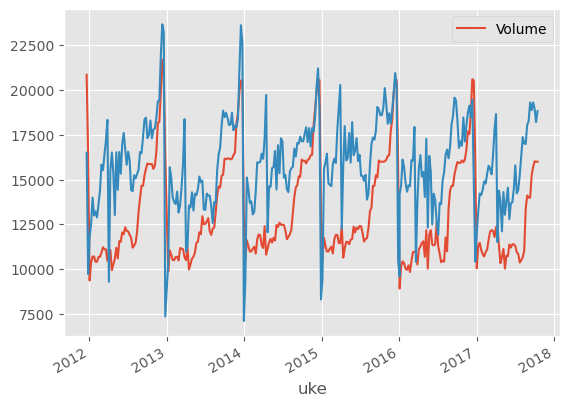

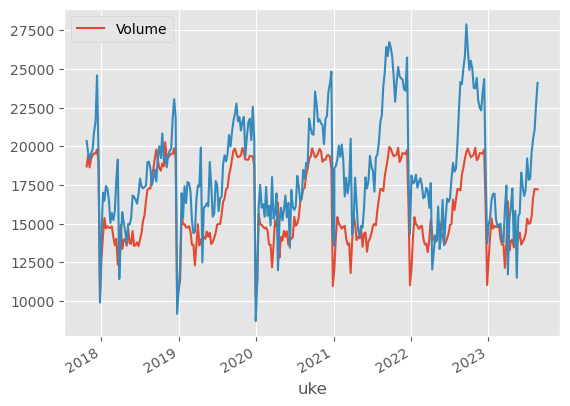

In [93]:

tscv = TimeSeriesSplit(n_splits=3)

features = ['Year', 'Week', 'Month', 'Day of year', 'Currency']
targets = ['Volume']

reg_model = xgb.XGBRegressor(
    n_estimators=10000, 
    early_stopping_rounds=1000, 
    learning_rate=0.1
)

# Iterate over the time series splits
for train_index, test_index in tscv.split(salmon_data.copy()):
    X_train, X_test = salmon_data[features].iloc[train_index], salmon_data[features].iloc[test_index]
    y_train, y_test = salmon_data[targets].iloc[train_index], salmon_data[targets].iloc[test_index]

    # Fit the XGBoost model
    reg_model.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False
    )

    # Make predictions
    y_pred = reg_model.predict(X_test)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")

    fi = pd.DataFrame(data=reg_model.feature_importances_, index=reg_model.feature_names_in_, columns=['Importance'])
    display(fi)

    predictions = pd.DataFrame(reg_model.predict(X_test), columns=targets, index=X_test.index)

    fig, ax = plt.subplots()

    predictions.plot(ax=ax)
    ax.plot(y_test)
    


## Model prediction

In [95]:
fi = pd.DataFrame(data=reg_model.feature_importances_, index=reg_model.feature_names_in_, columns=['Importance'])
display(fi)

future_dates = pd.DataFrame(
    pd.date_range(
        start=salmon_data.index[-1], 
        end='2025-12-24'
    ), columns=['Date']
)

future_dates.set_index(future_dates['Date'], inplace=True)
add_lags(future_dates)

future_dates.drop('Date', axis=1, inplace=True)

display(future_dates)

predictions = pd.DataFrame(reg_model.predict(future_dates), columns=targets, index=future_dates.index)

fig, axs = plt.subplots(2, figsize=(12, 12))

data_types = ['Training data', 'Testing data', 'Prediction']
label = ['NOK', 'Tonnes/week']
title = ['Salmon price', 'Salmon exported']

for i, target in enumerate(['Kilopris (kr)', 'Vekt (tonn)']):
    for j, data in enumerate([y_train, y_test, predictions]):
        data[target].plot(ax=axs[i], label=data_types[j])
        axs[i].legend(fontsize=15, frameon=False)
        axs[i].grid(alpha=0.4)
        axs[i].set_ylabel(label[i], fontsize=15)
        axs[i].set_title(title[i], fontsize=17)

fig.tight_layout()

# Week 43:
print('Week 43:')
display(pd.DataFrame(predictions.loc['2023-10-23']))

,Importance
Year,0.783588
Week,0.099732
Month,0.057493
Day of year,0.048963
Currency,0.010224


,Year,Week,Month,Day of year
Date,,,,
2023-08-21,2023,34,8,233
2023-08-22,2023,34,8,234
2023-08-23,2023,34,8,235
2023-08-24,2023,34,8,236
2023-08-25,2023,34,8,237
...,...,...,...,...
2025-12-20,2025,51,12,354
2025-12-21,2025,51,12,355
2025-12-22,2025,52,12,356


ValueError: Feature shape mismatch, expected: 5, got 4